In [5]:
# Import necessary libraries, modules, and function
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.optimize import curve_fit

In [31]:
# Functions definition
def classifyInhibitor(inhibitor, Vmax, Km, Vmax_app, Km_app, relative_tolerance=0.3):
    """Classifies the type of enzyme 'inhibitor' into Uncompetitive, Competitive, or Noncompetitive inhibitor based on given kinetic parameters.
        inhibitor (str): name of the inhibitor.
        Vmax (float):  maximum reaction velocity without the inhibitor.
        Km (float): Michaelis constant (substrate concentration at half-maximal velocity) without the inhibitor.
        Vmax_app (float): apparent maximum reaction velocity with the 'inhibitor'.
        Km_app (float): apparent Michaelis constant with the inhibitor.
        relative_tolerance (float, optional): Tolerance to determine if Vmax is unchanged (default is 0.3)."""
    
    if Vmax_app < Vmax and Km_app < Km:
        print(inhibitor + ': Uncompetitive Inhibitor')
        return 'Uncompetitive Inhibitor'
    elif Km_app > Km and math.isclose(Vmax_app, Vmax, rel_tol=relative_tolerance):
        print(inhibitor + ': Competitive Inhibitor')
        return 'Competitive Inhibitor'
    elif Vmax_app < Vmax:
        print(inhibitor + ': Noncompetitive Inhibitor')
        return 'Noncompetitive Inhibitor'
    else:
        print(inhibitor + ': No specific inhibition type identified')
        
def michaelisMenten(S, Vmax, Km):
    """Sets up Michaelis-Menten equation to return the rate of enzyme-catalyzed reaction with given kinetic parameters, 
    in which v=(Vmax * S) / (Km + S)"""
    return (Vmax * S) / (Km + S)

def michaelisMentenRegression(dataLabel, dataColor, subConcentration, *trialRateSet):
    """Generates non-linear regression fitting curve for Michaelis-Menten equation with given numbers of trial data set. All experimental data points
    and fitting curve are displayed.
        subConcentration (list): substrate's concentration set
        *trialRateSet (list): sets of reaction rates
        dataLabel (str): label for scattering points and plotting line 
        dataColor (str): color for scattering points and plotting line
    """
    aveRate = np.mean(np.array(trialRateSet), axis=0)
    para, _ = curve_fit(michaelisMenten, subConcentration, aveRate, bounds=(0, [3,3]))
    Vmax, Km = para
    subPts = np.linspace(0, max(subConcentration), 100)
    for i, trialRate in enumerate(trialRateSet):
        plt.scatter(subConcentration, trialRate, alpha=0.6, color=dataColor)
    plt.plot(subPts, michaelisMenten(subPts, *para), linestyle='--', color=dataColor, label=dataLabel)
    return para

In [33]:
# Load data file
bGfile = "bgalkinetics.xlsx"
bGdata = pd.read_excel(bGfile)

# Define known experimental data and constant
molarAbstvty = 4500 * 1e-3 # molar absorptivity of ONP (4500 mol/ml.cm)
runTime = [0.12, 0.97, 1.82, 2.67, 3.52, 4.37, 5.22, 6.07, 6.92] # Absorbance data recorded at these reaction times (minutes)
substrateConc = [0.078125, 0.15625, 0.3125, 0.625, 1.25, 2.5, 5] # Concentrations of the substrate ONPG (mM)

# Initialize lists and dictionaries to store results from later analysis 
absorbanceRates = [] # list to store calculated absorbance rate for each well
nameTags = [] # list to store generated nametags for well's identification
absRates = {} # dictionary to store absorbance rate with its right nametag
trioAbsRates = {} # dictionary to store the average of absorbance rates of every three same trials with its right nametag
recipAbsRates = {} # dictionary to store the reciprocal of the average absorbance rate
recipSubsConc = [] # list to store the reciprocal of substrate concentration
lineBurkData = {'Beta-galactosidase': [], 'L-Arabonise': [], 'IPTG': [], 'Theophylline': []} # list to store the categorized recipAbsRates data 
michelMenData = {'Beta-galactosidase': [[], [], []],'L-Arabonise': [[], [], []],'IPTG': [[], [], []],'Theophylline': [[], [], []]} # list to store the categorised absorbance rates data 

In [35]:
# Calculate absorbance rates for all wells 
for cols in bGdata.columns:
    slope, intercept = np.polyfit(runTime, bGdata[cols], 1)
    absorbanceRates.append(slope/molarAbstvty)

# Create nametag list
for tag in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']:
    for ez in ['Bgl', 'L', 'IPTG', 'Theo']:
        for num in ['1', '2', '3']:
            nameTags.append(f"{tag}{num}{ez}")         

# Assign each well with the right nametag 
for key, value in zip(nameTags, absorbanceRates):
    absRates[key] = value

# Eliminate unimportant data points ([S]=0)
cleanAbsRates = {key: value for key, value in absRates.items() if 'a' not in key}
rates = list(cleanAbsRates.values())
keys = list(cleanAbsRates.keys())

# Calculate average absorbance rate of every three same trials
for i in range(0, len(list(cleanAbsRates.values())), 3):
    avgRate = sum(rates[i:i+3]) / 3
    key = keys[i]
    trioAbsRates[key] = avgRate 
    
# Calculate reciprocal of the average absorbance rate
for key, value in trioAbsRates.items():
    recipAbsRates[key] = round(1 / (value), 2)

# Calculate the reciprocal of substrate concentration
for conc in substrateConc:
    oneToConc = 1 / conc
    recipSubsConc.append(round(oneToConc, 2))

In [37]:
# Build Lineweaver-Burk Data set
for key, value in recipAbsRates.items():
    if 'Bgl' in key:
        lineBurkData['Beta-galactosidase'].append(value)
    elif 'L' in key:
        lineBurkData['L-Arabonise'].append(value)
    elif 'IPTG' in key:
        lineBurkData['IPTG'].append(value)
    elif 'Theo' in key:
        lineBurkData['Theophylline'].append(value)

lineBurkDf = pd.DataFrame(lineBurkData)
lineBurkDf.insert(0, '1/[S]', recipSubsConc)

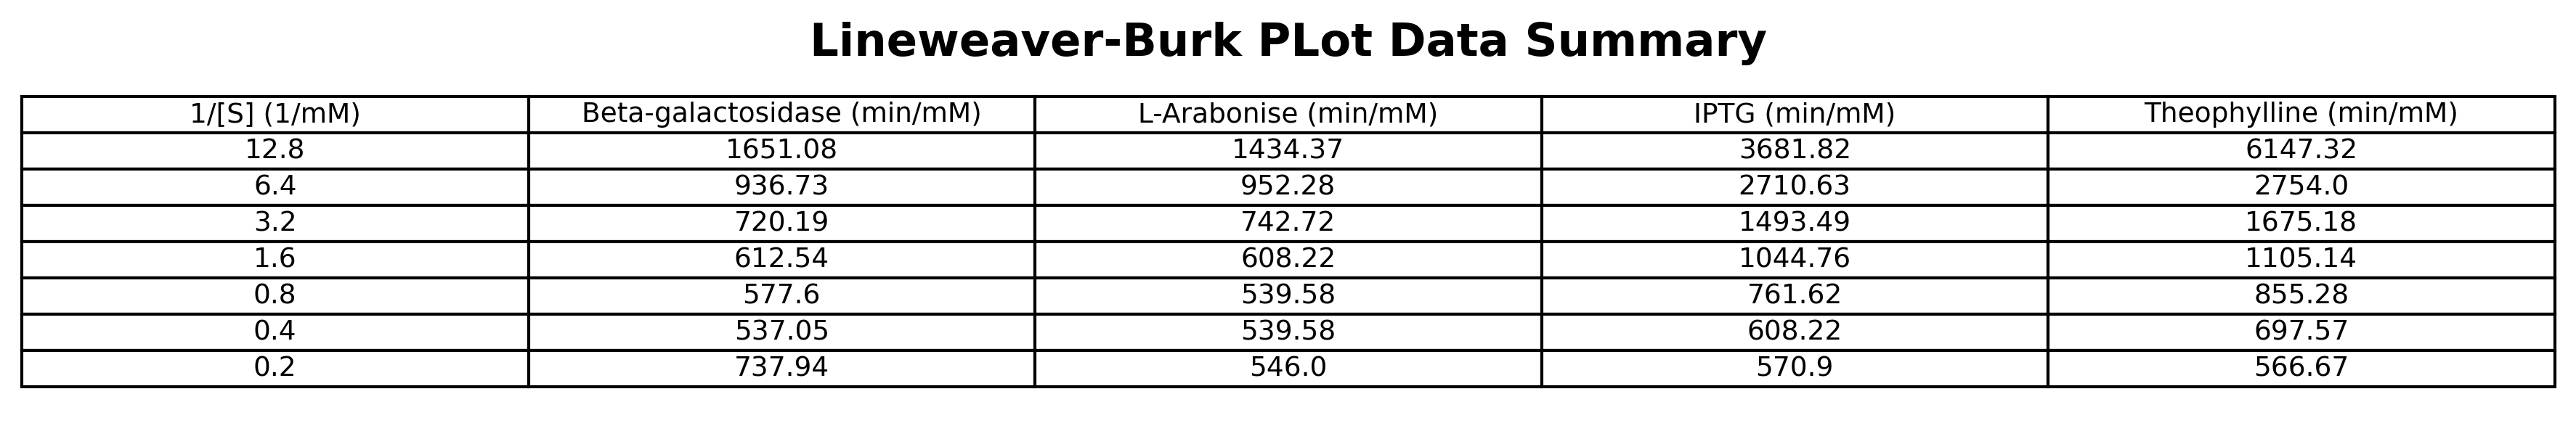

In [39]:
# Display Lineweaver-Burk data summary table
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.axis('tight')
ax.axis('off')
dataLabels = ['1/[S] (1/mM)', 'Beta-galactosidase (min/mM)', 'L-Arabonise (min/mM)', 'IPTG (min/mM)', 'Theophylline (min/mM)']
ax.set_title('Lineweaver-Burk PLot Data Summary', fontsize=15, fontweight='bold')  
table = ax.table(cellText=lineBurkDf.values,colLabels=dataLabels, cellLoc='center', loc='center')

In [40]:
# Calculate slope and y-intercept from data
s1, inc1 = np.polyfit(lineBurkDf['1/[S]'], lineBurkDf['Beta-galactosidase'], 1)
s2, inc2 = np.polyfit(lineBurkDf['1/[S]'], lineBurkDf['L-Arabonise'], 1)
s3, inc3 = np.polyfit(lineBurkDf['1/[S]'], lineBurkDf['IPTG'], 1)
s4, inc4 = np.polyfit(lineBurkDf['1/[S]'], lineBurkDf['Theophylline'], 1)

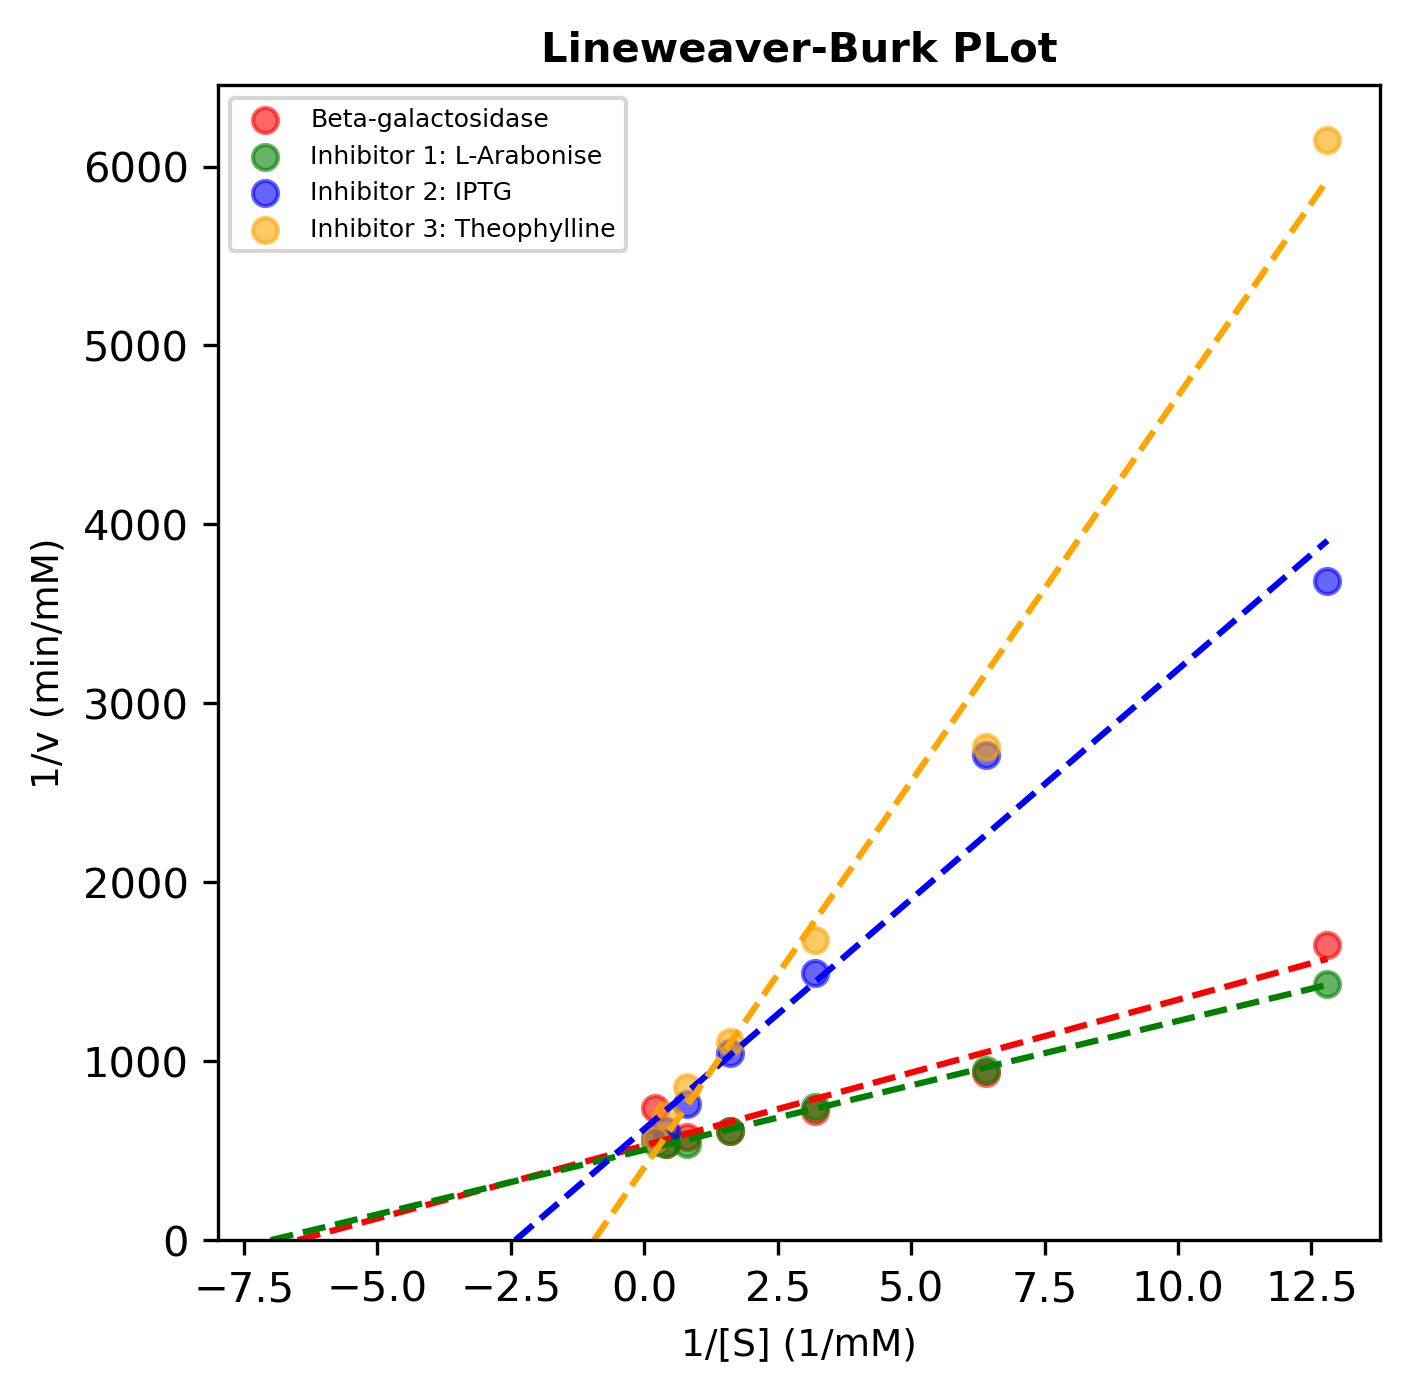

In [43]:
# Plot Lineweaver-Burk scattering points
plt.figure(figsize=(5,5),dpi=300)
plt.scatter(lineBurkDf['1/[S]'], lineBurkDf['Beta-galactosidase'], color='red', label='Beta-galactosidase', alpha=0.6)
plt.scatter(lineBurkDf['1/[S]'], lineBurkDf['L-Arabonise'], color='green', label='Inhibitor 1: L-Arabonise', alpha=0.6)
plt.scatter(lineBurkDf['1/[S]'], lineBurkDf['IPTG'], color='blue', label='Inhibitor 2: IPTG', alpha=0.6)
plt.scatter(lineBurkDf['1/[S]'], lineBurkDf['Theophylline'], color='orange', label='Inhibitor 3: Theophylline', alpha=0.6)

# Plot Lineweaver-Burk fitted lines using the correct slope and intercept values
plt.plot([-inc1/s1, min(lineBurkDf['1/[S]']), max(lineBurkDf['1/[S]'])],
         [0, s1 * min(lineBurkDf['1/[S]']) + inc1, s1 * max(lineBurkDf['1/[S]']) + inc1], color='red', linestyle='--')
plt.plot([-inc2/s2, min(lineBurkDf['1/[S]']), max(lineBurkDf['1/[S]'])],
         [0, s2 * min(lineBurkDf['1/[S]']) + inc2, s2 * max(lineBurkDf['1/[S]']) + inc2], color='green', linestyle='--')
plt.plot([-inc3/s3, min(lineBurkDf['1/[S]']), max(lineBurkDf['1/[S]'])],
         [0, s3 * min(lineBurkDf['1/[S]']) + inc3, s3 * max(lineBurkDf['1/[S]']) + inc3], color='blue', linestyle='--')
plt.plot([-inc4/s4, min(lineBurkDf['1/[S]']), max(lineBurkDf['1/[S]'])],
         [0, s4 * min(lineBurkDf['1/[S]']) + inc4, s4 * max(lineBurkDf['1/[S]']) + inc4], color='orange', linestyle='--')

plt.ylim(bottom=0)
plt.xlabel('1/[S] (1/mM)', fontsize=9)
plt.ylabel('1/v (min/mM)', fontsize=9)
plt.title('Lineweaver-Burk PLot',  fontweight='bold', fontsize=10)
plt.legend(fontsize=6)
plt.show()

In [45]:
# Calculate Vmax and KM 
vMaxBgal = 1 / inc1
vMaxL = 1 / inc2
vMaxIPTG = 1 / inc3
vMaxTheo = 1 / inc4

kMBgal = vMaxBgal * s1
kML = vMaxBgal * s2
kMIPTG = vMaxBgal * s3
kMTheo = vMaxBgal * s4

In [47]:
# Print out inhibitor type
c1 = classifyInhibitor("L-Arabonise", vMaxBgal, kMBgal, vMaxL, kML)
c2 = classifyInhibitor("IPTG", vMaxBgal, kMBgal, vMaxIPTG, kMIPTG)
c3 = classifyInhibitor("Theophylline", vMaxBgal, kMBgal, vMaxTheo, kMTheo)

L-Arabonise: No specific inhibition type identified
IPTG: Competitive Inhibitor
Theophylline: Competitive Inhibitor


In [49]:
# Build Michelis-Menten Data set
for key, value in cleanAbsRates.items():
    if 'Bgl' in key:
        if "1" in key:
            michelMenData['Beta-galactosidase'][0].append(value)
        elif "2" in key:
            michelMenData['Beta-galactosidase'][1].append(value)
        elif "3" in key:
            michelMenData['Beta-galactosidase'][2].append(value)
    elif 'L' in key:
        if "1" in key:
            michelMenData['L-Arabonise'][0].append(value)
        elif "2" in key:
            michelMenData['L-Arabonise'][1].append(value)
        elif "3" in key:
            michelMenData['L-Arabonise'][2].append(value)
    elif 'IPTG' in key:
        if "1" in key:
            michelMenData['IPTG'][0].append(value)
        elif "2" in key:
            michelMenData['IPTG'][1].append(value)
        elif "3" in key:
            michelMenData['IPTG'][2].append(value)
    elif 'Theo' in key:
        if "1" in key:
            michelMenData['Theophylline'][0].append(value)
        elif "2" in key:
            michelMenData['Theophylline'][1].append(value)
        elif "3" in key:
            michelMenData['Theophylline'][2].append(value)

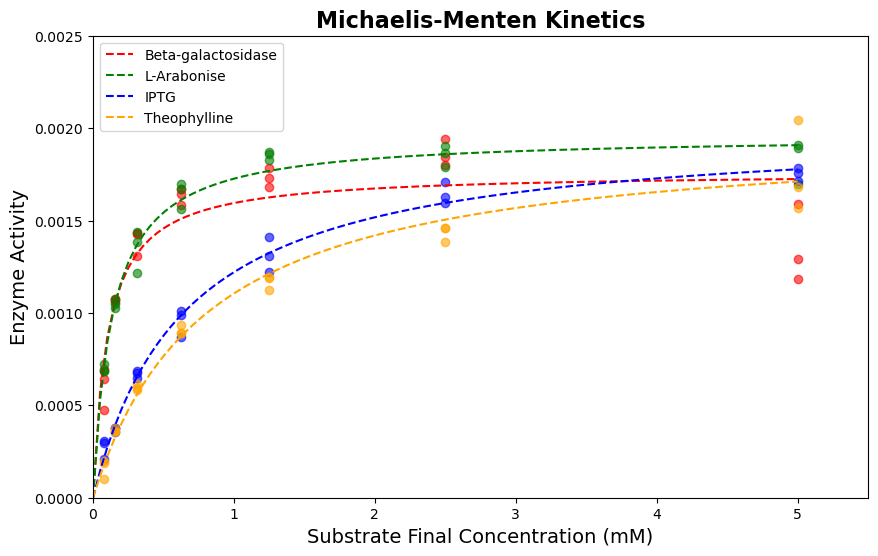

In [51]:
# Plot Michelis-Menten Data
plt.figure(figsize=(10, 6))
michaelisMentenRegression('Beta-galactosidase','red', substrateConc, 
                                    michelMenData['Beta-galactosidase'][0],
                                    michelMenData['Beta-galactosidase'][1],
                                    michelMenData['Beta-galactosidase'][2])
michaelisMentenRegression('L-Arabonise','green', substrateConc,
                                    michelMenData['L-Arabonise'][0],
                                    michelMenData['L-Arabonise'][1],
                                    michelMenData['L-Arabonise'][2])
michaelisMentenRegression('IPTG','blue', substrateConc,
                                    michelMenData['IPTG'][0],
                                    michelMenData['IPTG'][1],
                                    michelMenData['IPTG'][2])
michaelisMentenRegression('Theophylline','orange', substrateConc,
                                    michelMenData['Theophylline'][0],
                                    michelMenData['Theophylline'][1],
                                    michelMenData['Theophylline'][2])

plt.title('Michaelis-Menten Kinetics', fontsize=16, fontweight='bold')
plt.ylim(0,0.0025)
plt.xlim(0,5.5)
plt.xlabel('Substrate Concentration (mM)', fontsize=14)
plt.ylabel('Enzyme Activity', fontsize=14)
plt.legend()
plt.show()
